In [1]:
import numpy as np, matplotlib.pyplot as plt

In [2]:
def make_pgse_gradient(dt=0.1, n_delta=300, n_gap=200, G_amp=2.0, gamma=26.75):
    """
    PGSE gradient waveform in Gauss/cm, ms units.

    Parameters
    ----------
    dt      : float, ms
    n_delta : int, number of time steps in each pulse
    n_gap   : int, time steps between pulses (between leading edges = n_delta + n_gap)
    G_amp   : float, Gauss/cm, gradient magnitude during pulses
    gamma   : float, rad/(ms*G), gyromagnetic ratio

    Returns
    -------
    t         : (N,) array, ms
    G_scalar  : (N,) array, Gauss/cm (signed)
    dt        : float, ms
    delta     : float, ms
    big_delta : float, ms
    gamma     : float, rad/(ms*G)
    """
    n_big_delta = n_delta + n_gap
    n_total = n_big_delta + n_delta

    t = np.arange(n_total) * dt
    G_scalar = np.zeros(n_total)
    G_scalar[0:n_delta] = G_amp
    G_scalar[n_big_delta:n_big_delta + n_delta] = -G_amp

    delta = n_delta * dt
    big_delta = n_big_delta * dt
    return t, G_scalar, dt, delta, big_delta, gamma

In [5]:
def simulate_anisotropic_2d(
    D_x=1.5e-8,        # cm^2/ms (fast axis)
    D_y=5.0e-9,        # cm^2/ms (slow axis)
    theta_deg=0.0,     # gradient direction angle (0° = +x, 90° = +y)
    n_spins=50000,
    G_amp=2.0,         # Gauss/cm
    n_delta=300,
    n_gap=200,
    dt=0.1,            # ms
    gamma=26.75,       # rad/(ms*G)
    seed=0,
    Lx_cm=None,        # if not None: box width in x (cm), domain [-Lx/2, Lx/2]
    Ly_cm=None         # if not None: box height in y (cm), domain [-Ly/2, Ly/2]
):
    """
    Simulate 2D anisotropic diffusion with PGSE.

    Units:
      - x,y in cm
      - t in ms
      - D_x, D_y in cm^2/ms
      - G in Gauss/cm
      - gamma in rad/(ms*G)

    If Lx_cm or Ly_cm are given, spins bounce off reflecting walls:
      x in [-Lx_cm/2, +Lx_cm/2], y in [-Ly_cm/2, +Ly_cm/2].

    Returns
    -------
    S_sim      : complex, simulated signal
    S_mag_sim  : float, |S_sim|
    S_ST       : float, ST prediction using D_eff (only exact for free diffusion)
    b_ms_cm2   : float, b-value in ms/cm^2
    D_eff      : float, effective D along gradient direction (cm^2/ms)
    t, G_scalar, delta, big_delta : waveform info
    """
    if seed is not None:
        np.random.seed(seed)

    # 1) Gradient waveform (scalar magnitude vs time)
    t, G_scalar, dt, delta, big_delta, gamma = make_pgse_gradient(
        dt=dt, n_delta=n_delta, n_gap=n_gap, G_amp=G_amp, gamma=gamma
    )
    n_total = len(t)

    # 2) Gradient direction
    theta = np.deg2rad(theta_deg)
    cos_th, sin_th = np.cos(theta), np.sin(theta)

    # 3) Positions and phase
    x = np.zeros(n_spins)   # cm
    y = np.zeros(n_spins)   # cm
    phi = np.zeros(n_spins) # rad

    # 4) Diffusion step sigmas
    step_x = np.sqrt(2 * D_x * dt)  # cm
    step_y = np.sqrt(2 * D_y * dt)  # cm

    # Precompute box limits (centered at 0)
    if Lx_cm is not None:
        x_left  = -Lx_cm / 2.0
        x_right =  Lx_cm / 2.0
    if Ly_cm is not None:
        y_bottom = -Ly_cm / 2.0
        y_top    =  Ly_cm / 2.0

    for k in range(n_total):
        # --- anisotropic diffusion step ---
        x += step_x * np.random.randn(n_spins)
        y += step_y * np.random.randn(n_spins)

        # --- reflecting walls (if enabled) ---
        if Lx_cm is not None:
            mask = x < x_left
            x[mask] = 2*x_left - x[mask]
            mask = x > x_right
            x[mask] = 2*x_right - x[mask]

        if Ly_cm is not None:
            mask = y < y_bottom
            y[mask] = 2*y_bottom - y[mask]
            mask = y > y_top
            y[mask] = 2*y_top - y[mask]

        # --- gradient components at this time ---
        Gx = G_scalar[k] * cos_th  # Gauss/cm
        Gy = G_scalar[k] * sin_th  # Gauss/cm

        # --- phase increment ---
        phi += gamma * (Gx * x + Gy * y) * dt

    # Simulated signal
    S_sim = np.mean(np.exp(1j * phi))
    S_mag_sim = np.abs(S_sim)

    # Effective D along gradient direction (for *free* Gaussian diffusion)
    D_eff = D_x * cos_th**2 + D_y * sin_th**2  # cm^2/ms

    # b-value (same formula as 1D)
    b_ms_cm2 = gamma**2 * G_amp**2 * delta**2 * (big_delta - delta/3.0)

    # ST prediction (only exact when Lx_cm, Ly_cm are None)
    S_ST = np.exp(-b_ms_cm2 * D_eff)

    return S_sim, S_mag_sim, S_ST, b_ms_cm2, D_eff, t, G_scalar, delta, big_delta

### Free vs Unrestricted

In [6]:
# Parameters
D_x = 1.5e-8   # cm^2/ms
D_y = 5.0e-9   # cm^2/ms

# Free diffusion, theta = 0°
S_sim_free, S_mag_free, S_ST_free, b_ms_cm2, D_eff, *_ = simulate_anisotropic_2d(
    D_x=D_x, D_y=D_y, theta_deg=0.0,
    Lx_cm=None, Ly_cm=None
)

# Restricted to a 10 µm x 10 µm box (remember: 10 µm = 1e-3 cm)
S_sim_box, S_mag_box, S_ST_box, *_ = simulate_anisotropic_2d(
    D_x=D_x, D_y=D_y, theta_deg=0.0,
    Lx_cm=1e-3, Ly_cm=1e-3
)

# Convert b to s/mm^2 just for reporting
b_s_mm2 = b_ms_cm2 * 1e-5
print(f"b ≈ {b_s_mm2:.1f} s/mm²")
print(f"|S_free| ≈ {S_mag_free:.3f},  ST prediction ≈ {S_ST_free:.3f}")
print(f"|S_box | ≈ {S_mag_box:.3f}  (restricted, attenuates less)")

b ≈ 1030.4 s/mm²
|S_free| ≈ 0.217,  ST prediction ≈ 0.213
|S_box | ≈ 0.932  (restricted, attenuates less)


### Rotating gradient

b ≈ 1030.4 s/mm^2


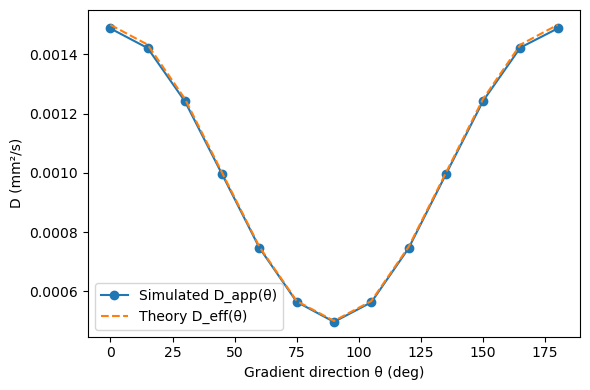

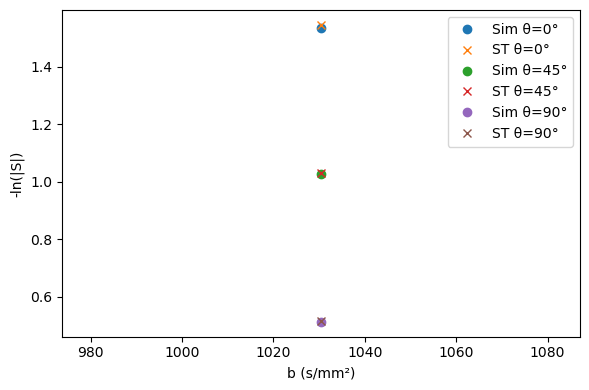

In [4]:
# Example anisotropy: Dx > Dy
D_x = 1.5e-8   # cm^2/ms  (≈ 1.5 x 10^-3 mm^2/s)
D_y = 5.0e-9   # cm^2/ms  (≈ 0.5 x 10^-3 mm^2/s)

thetas = np.linspace(0, 180, 13)  # 0,15,...,180
sim_D_app = []
theory_D_eff = []

b_vals_ms_cm2 = None   # will record one b (same for all θ)
sim_mags = []
st_mags = []

for th in thetas:
    S_sim, S_mag_sim, S_ST, b_ms_cm2, D_eff, *_ = simulate_anisotropic_2d(
        D_x=D_x, D_y=D_y, theta_deg=th,
        n_spins=80000, G_amp=2.0,
        n_delta=300, n_gap=200,
        dt=0.1, gamma=26.75, seed=0
    )
    if b_vals_ms_cm2 is None:
        b_vals_ms_cm2 = b_ms_cm2

    sim_mags.append(S_mag_sim)
    st_mags.append(S_ST)

    # Apparent D from simulation at this b: D_app = -ln(S)/b
    D_app = -np.log(S_mag_sim + 1e-12) / b_ms_cm2
    sim_D_app.append(D_app)
    theory_D_eff.append(D_eff)

sim_D_app   = np.array(sim_D_app)
theory_D_eff = np.array(theory_D_eff)

# Convert b to s/mm^2 for a "real" axis label
b_s_mm2 = b_vals_ms_cm2 * 1e-5

print(f"b ≈ {b_s_mm2:.1f} s/mm^2")

# ---- Plot 1: D_app(theta) vs theoretical D_eff(theta) ----
# Convert D to mm^2/s for nicer numbers
D_to_mm2_s = 1e5  # (cm^2/ms) * 1e5 = mm^2/s
plt.figure(figsize=(6,4))
plt.plot(thetas, sim_D_app * D_to_mm2_s, "o-", label="Simulated D_app(θ)")
plt.plot(thetas, theory_D_eff * D_to_mm2_s, "--", label="Theory D_eff(θ)")
plt.xlabel("Gradient direction θ (deg)")
plt.ylabel("D (mm²/s)")
plt.legend()
plt.tight_layout()
plt.show()

# ---- Plot 2: -ln(|S|) vs b for a couple of directions ----
# e.g. θ = 0° (fast), 90° (slow)
plt.figure(figsize=(6,4))
for th in [0, 45, 90]:
    S_sim, S_mag_sim, S_ST, b_ms_cm2, D_eff, *_ = simulate_anisotropic_2d(
        D_x=D_x, D_y=D_y, theta_deg=th,
        n_spins=80000, G_amp=2.0,
        n_delta=300, n_gap=200,
        dt=0.1, gamma=26.75, seed=0
    )
    y_sim = -np.log(S_mag_sim + 1e-12)
    y_th  = b_ms_cm2 * D_eff
    plt.plot([b_ms_cm2 * 1e-5], [y_sim], "o", label=f"Sim θ={th}°")
    plt.plot([b_ms_cm2 * 1e-5], [y_th], "x", label=f"ST θ={th}°")

plt.xlabel("b (s/mm²)")
plt.ylabel("-ln(|S|)")
plt.legend()
plt.tight_layout()
plt.show()